# Section 8.3 Lab: Decision Trees

## Fitting Classification Trees

In [1]:
library(ISLR)
library(tree)
library(magrittr)

Were are going to predict the *Sales* variable from `Carseats` dataset. *Sales* is a continuous variable so we begin by recording it as as a new binary variable called *High* with the `ifelse()` function, to assing the value of **Yes** i the *Sales* exceeds 8, and **No** otherwise.

In [2]:
attach(Carseats)

In [3]:
High = ifelse(Sales<=8, "No", "Yes")

In [4]:
Carseats = data.frame(Carseats, High)
str(Carseats)

'data.frame':	400 obs. of  12 variables:
 $ Sales      : num  9.5 11.22 10.06 7.4 4.15 ...
 $ CompPrice  : num  138 111 113 117 141 124 115 136 132 132 ...
 $ Income     : num  73 48 35 100 64 113 105 81 110 113 ...
 $ Advertising: num  11 16 10 4 3 13 0 15 0 0 ...
 $ Population : num  276 260 269 466 340 501 45 425 108 131 ...
 $ Price      : num  120 83 80 97 128 72 108 120 124 124 ...
 $ ShelveLoc  : Factor w/ 3 levels "Bad","Good","Medium": 1 2 3 3 1 1 3 2 3 3 ...
 $ Age        : num  42 65 59 55 38 78 71 67 76 76 ...
 $ Education  : num  17 10 12 14 13 16 15 10 10 17 ...
 $ Urban      : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 1 2 2 1 1 ...
 $ US         : Factor w/ 2 levels "No","Yes": 2 2 2 2 1 2 1 2 1 2 ...
 $ High       : Factor w/ 2 levels "No","Yes": 2 2 2 1 1 2 1 2 1 1 ...


Now we use the `tree()` function to fit a classification tree in order to predict *High* using all the variables but *Sales*

In [5]:
tree.carseats =  tree(High ~ . - Sales, Carseats)

In [6]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

We can see that the training erro rate is 9%. For classfication trees, the deviance reported in the output of summary() is given by :

$$
-2\sum_{m}\sum_{k}n_{mk}log\hat p_{mk}
$$

where $n_{mk}$ is the number of observations in the *m*th terminal node that belong to the *k*th class. A small deviance indicates a tree that provides a good fit to the (trainig) data. The *residual mean deviance* reported is simply the deviance divided by $n-|T_0|$.

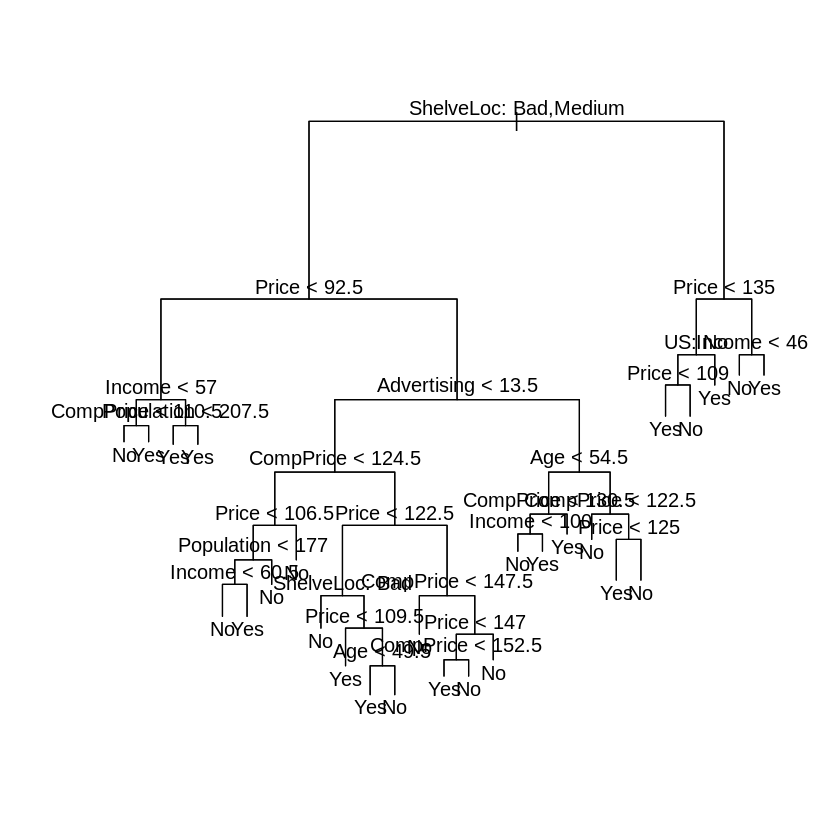

In [7]:
plot(tree.carseats)
text(tree.carseats, pretty = 0)

The most important indicator of *Sales* appears to be shelving location, since hte first branch differentiates **Good** locations from **Bad** and **Medium** locations.

If we just type the name of the tree object, *R* prints ouptut corresponding to each branch of the tree

In [8]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

*R* displays
* split criterion : 
* nº obs in that branch
* deviance
* overall prediction for the branch (**Yes** or **No**)
* fracto of obs in that branch that take values of **Yes** and **No**

Branches that lead to terminal nodes are indicates using asterisks.

In order to properly evaluate the performance of a classificatio tree on these data, we must estimate the test error rather than simply computing the trainig error.

In [14]:
set.seed(2)
train = sample(1:nrow(Carseats),200)
Carseats.test = Carseats[-train,]
High.test = High[-train]
tree.carseats = tree(High ~ .-Sales, Carseats, subset = train)
tree.pred = predict(tree.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

In [10]:
ACC_f = function(TN,TP,FN,FP){
    return( (TN + TP) / (TN+TP+FN+FP) )
}

In [16]:
ACC_f(104,50,13,33)  %>% round(3)

[1] 0.77

This approach leads to correct predictions for around 77% fo the location in the test dataset

Next we considerer wheter prunning the tree might lead to improved results. The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity. We use the argument `FUN=prune.misclass` in order to indicate that we want the calssification error rate to guide the cross-validation and pruning process, rather than the default for `cv.tree()` which is deviance.

In [17]:
set.seed(3)
cv.carseats = cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)

[1] "size"   "dev"    "k"      "method"


$k$ correspond to $\alpha$ in

$$
\sum_{m=1}^{|T|}{\sum_{i:x_i \in R_m}{(y_i - \hat y_{R_{m}})^2 + \alpha |T|}}
$$

where 
* $T\subset T_0$
* $T_0$ is the very large tree that needs to be pruned
* $|T|$ indicates the number of terminal nodes of the tree $T$
* $R_m$ is the rectangle (i.e the subset of predictor space) corresponding to the $m$th terminal node
* $\hat y_{R_{m}}$ os the predicted response associated with $R_m$ -that is the mean of the training obs in $R_m$


$\alpha$ is the tunning parameter that controls a trade-off between the subree's complexity and its fit to the training data

In [18]:
cv.carseats

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 74 76 81 81 75 77 78 85 81

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Note that the name `dev` corresponds to the cross-validation error rate in this instance. The tree with 21 terminal nodes result in the lowest cross-validation error rate, with 74 cross-validation errors

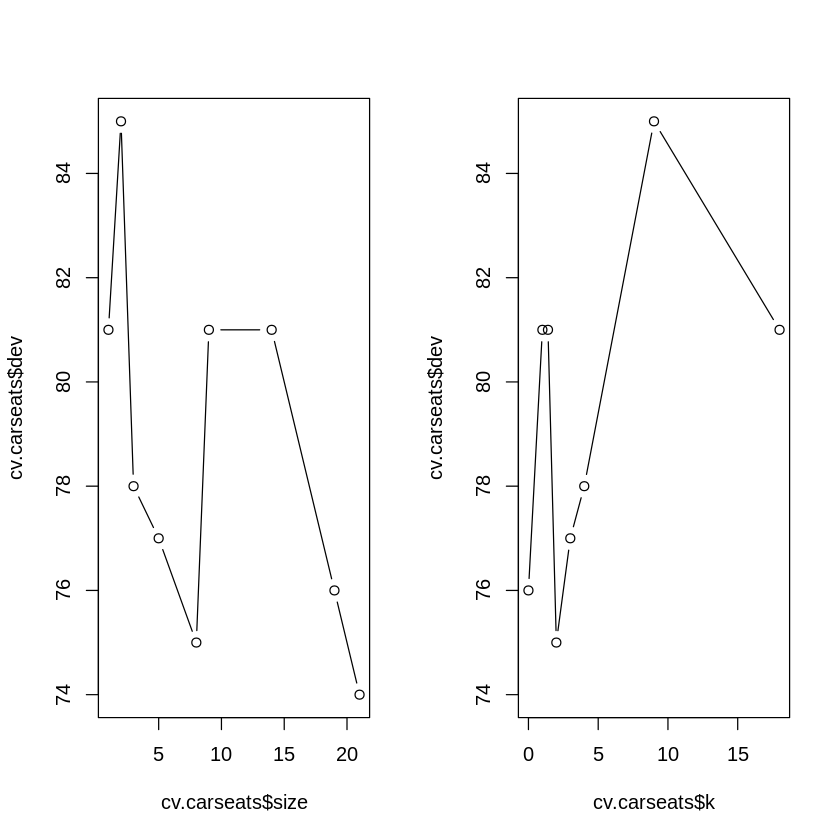

In [19]:
par(mfrow = c(1,2))
plot(cv.carseats$size, cv.carseats$dev, type =  "b")
plot(cv.carseats$k, cv.carseats$dev, type =  "b")

We now apply the `prune.misclass()` function in order to prune the tree to obtain the 9 node tree.

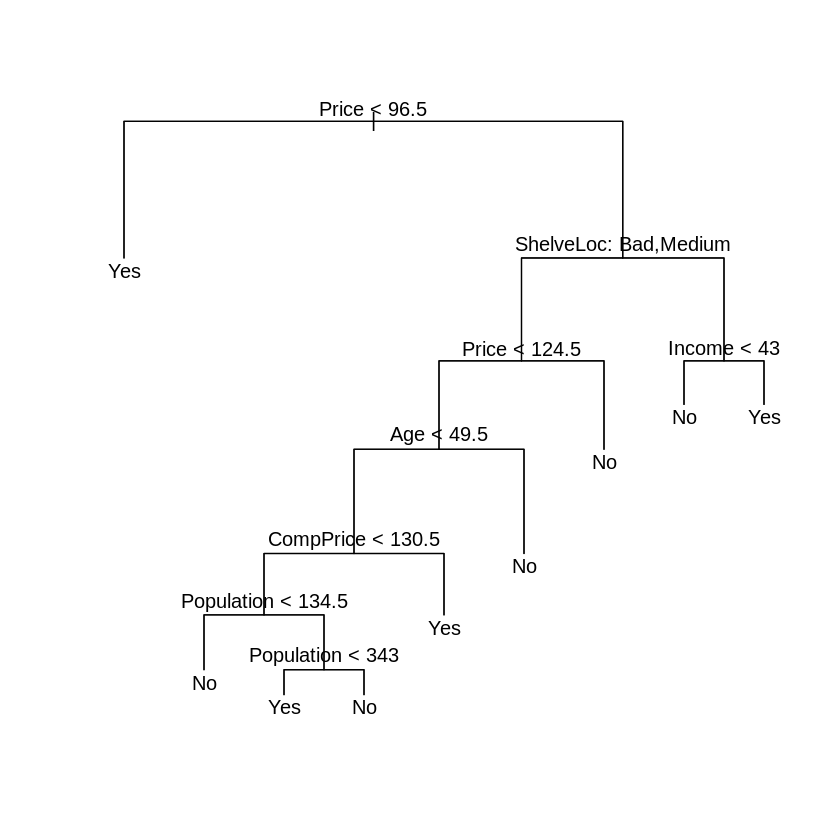

In [30]:
set.seed(3)
prune.carseats = prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

In [34]:
set.seed(3)
tree.pred = predict(prune.carseats, Carseats.test, type  = "class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

In [35]:
ACC_f(103,52,14,31)

[1] 0.775

Now we have a slightly improved accuracy, but with a more interpretable tree. (29 vs 9 terminal nodes)

Now there is the prunned tree with only 2 terminal nodes: 

         High.test
tree.pred  No Yes
      No  104  56
      Yes  13  27

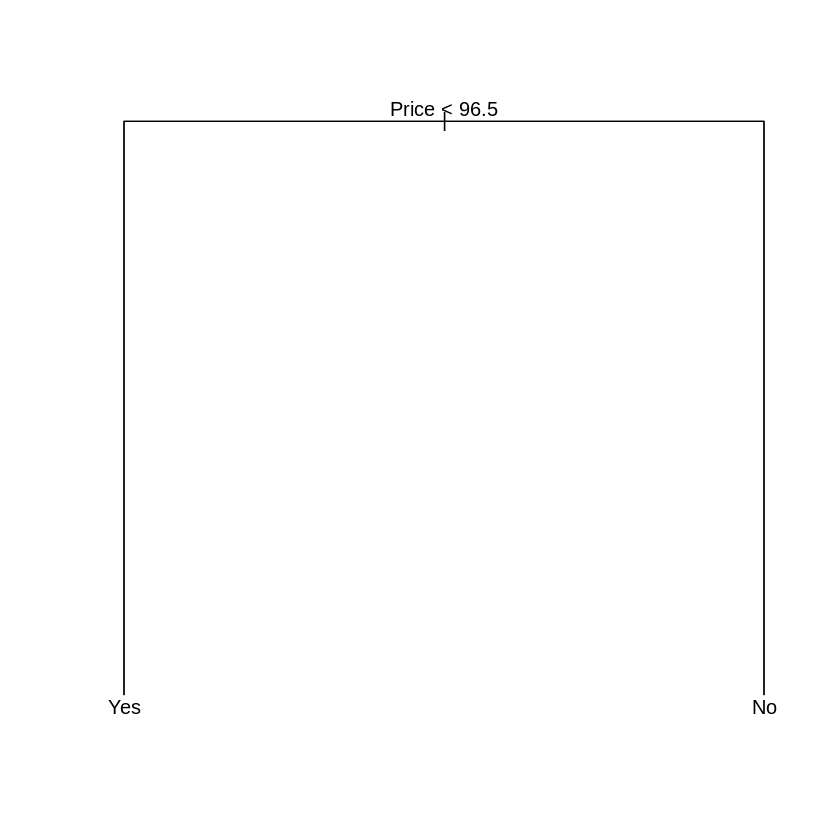

In [36]:
prune.carseats = prune.misclass(tree.carseats, best = 2)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

tree.pred = predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

In [27]:
ACC_f(104,27,13,56)

[1] 0.655

As expected the accuray is worse.

And finaly here is the tree with more terminal nodes than the chosen one (9) but with a similar accuracy.  

         High.test
tree.pred  No Yes
      No  102  31
      Yes  15  52

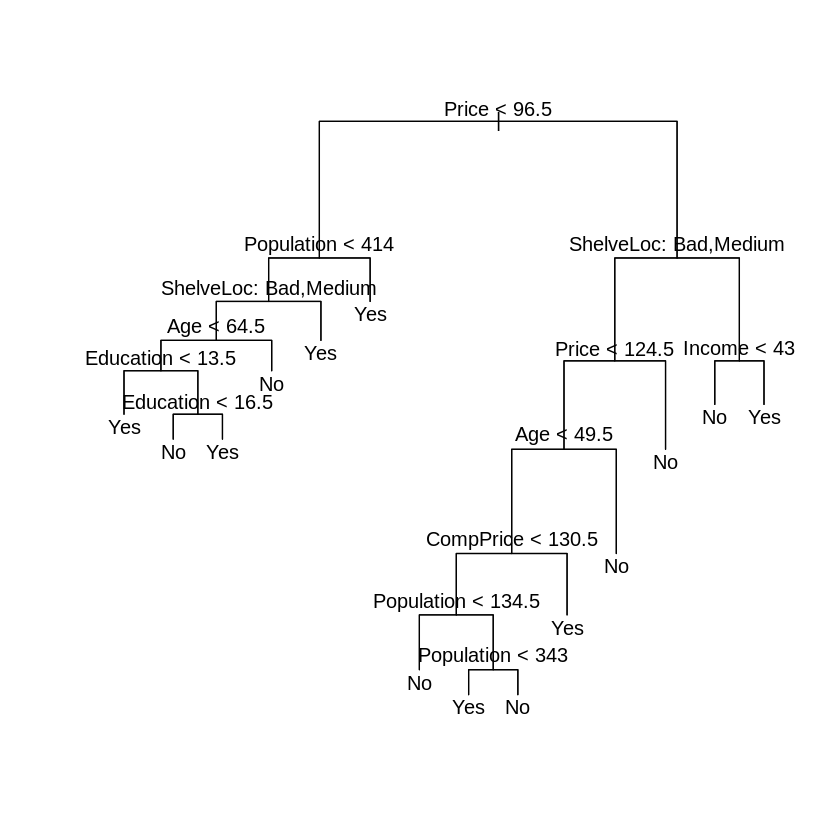

In [41]:
prune.carseats = prune.misclass(tree.carseats, best = 14)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

tree.pred = predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

In [42]:
ACC_f(102,52,15,31)

[1] 0.77

Hence we prefer the 9 nodes tree due to the better interpretability.